In [2]:
import numpy as np
import ctypes
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import fdrcorrection_twostage as fdr
import os
import argparse
import time
import matplotlib.pyplot as plt
from iotools.dosageparser import DosageParser
from iotools.readVCF import ReadVCF 
from scipy.optimize import minimize
from scipy.special import erfinv
from inference.regulizer_optimizer import OptimizeRegularizer
from select_genes_per_snp import linear_reg
#from qqplot import plot_hist_qq

In [3]:
def read_expression(filename):
    gene_names = list()
    expression = list()
    with open(filename, 'r') as genefile:
        header = genefile.readline()
        donorids = header.strip().split("\t")[1:]
        for line in genefile:
            linesplit = line.strip().split("\t")
            expression.append(np.array(linesplit[1:], dtype=float))
            gene_names.append(linesplit[0])
    expression = np.array(expression)
    return donorids, expression, gene_names


'''def norm_binom(genotype, f):
    genotype = (genotype - (2 * f)) / np.sqrt(2 * f * (1 - f))
    return genotype
'''

def parse_geno (genotype_filename, sample_filename, startsnp, endsnp):                              #Read genotype here
    ds        = DosageParser(genotype_filename, sample_filename, startsnp, endsnp)
    dosage    = ds.dosage
    snpinfo   = ds.snpinfo
    donorids  = ds.sample_id
    nsnps     = ds.nsnps
    nsample   = ds.nsample
    return dosage, snpinfo, donorids, nsnps, nsample

                                                                                                    #quality check, matching
def quality_check ( sampleids, donorids):
    choose_ids     = [x for x in sampleids if x in donorids]
    dosage_indices = [i for i, x in enumerate(donorids)  if x in choose_ids]
    exprsn_indices = [i for i, x in enumerate(sampleids) if x in choose_ids]
    return dosage_indices, exprsn_indices

def read_distance(filename):
    samplelist = list()
    distances = list()
    with open(filename, 'r') as mfile:
        mfile.readline()
        for line in mfile:
            linestrip = line.strip().split("\t")
            samplelist.append(linestrip[0])
            distances.append(np.array(linestrip[1:],dtype=float))
    return np.array(distances), samplelist

In [21]:
#out_fileprefix      = 
genotype_filename   = "data/geno/GTEx_450Indiv_genot_imput_info04_maf01_HWEp1E6_dbSNP135IDs_donorIDs_dosage_chr1.gz"
sample_filename     = "data/geno/donor_ids.fam"
#expression_filename = "PCA_KNN_Correction/main/expr.txt"
expression_filename = "data/expressions/GTEx_wholeBlood_Normalzed_NoPEER_lmcorrected.txt"

startsnp            = 1
endsnp              = 150000
optim               = 0
user_sigbeta        = 0.001636581825407
#transgeno           = opts.trans_genofile

In [22]:
sampleids, expression, gene_names = read_expression(expression_filename)

In [26]:
sigbeta = user_sigbeta


tic = time.time()
print ("\nReading Genotype")
dosage, snpinfo, donorids, nsnps, nsample = parse_geno ( genotype_filename, sample_filename, startsnp, endsnp)
dosage_indices, exprsn_indices = quality_check (sampleids , donorids)
conv_dosage = np.round(dosage)                                                                      #Best performance if dosages are rounded off
geno        = conv_dosage[:, dosage_indices]                                                    
#freq        = np.array([x.freq for x in snpinfo])
geno = ((geno.T - np.mean(geno.T,axis = 0)) / np.std(geno.T,axis = 0)).T

expr  = expression[:, exprsn_indices]
                                                                                                    # SXN
print ("Completed data loading and processing\n")

##################################################################################    
# choose_ids = [x for x in sampleids if x in donorids]
# distance, sample = read_distance("PCA_KNN_Correction/main/sample_distance_matrix.csv")
# distance_matrix = distance[exprsn_indices,:][:,exprsn_indices]

# k=12
 

# corrected_geno = np.zeros_like(geno)
# for i,j in enumerate(choose_ids):
#     distances = distance_matrix[i,:]
#     neighbors =np.argsort(distances)[: k+1]
#     corrected_geno[:, i] = geno[:, i] - np.mean(geno[:, neighbors[1:]], axis = 1)

# geno = corrected_geno
# geno = ((geno.T - np.mean(geno.T,axis = 0)) / np.std(geno.T,axis = 0)).T
#####################################################################################


ori_shuffled_genom = geno.copy()
for i in range(ori_shuffled_genom.shape[0]):
    idx = np.random.permutation(np.arange(0,ori_shuffled_genom.shape[1]))
    np.random.shuffle(idx)
    ori_shuffled_genom[i,:] = ori_shuffled_genom[i,idx]
                                                                                                    #randoms = np.random.choice(geno.shape[0], 30000)
                                                                                                    #genos = geno[randoms,:]
genotype = ori_shuffled_genom
#Calculate Qscores here
sigma_geno = 1
U, S, V_t = np.linalg.svd(np.transpose(expr),full_matrices=False)                                   #, Check this
fact = sigma_geno**2 / sigbeta**2
diagw = np.square(S) / (np.square(S) + fact)
Wsvd = np.dot(U, np.dot(np.diag(diagw), U.T))                                                       # Reverse because in the methods
Rsvd  = np.diag(np.dot(genotype, np.dot(Wsvd,  genotype.T)))                                        # geno should be SNP X Sample

                                                                                                    #Inference parameters



In [38]:
############ after update on 22 May 2018 ##############

Rmean    = np.sum(diagw)
#Rvar     = 2*(np.sum(np.square(diagw))) + (np.mean(genotype**4, axis = 1) - 3) * np.sum(np.square(np.diag(Wsvd)))
Rvar = (np.sum(np.sum(Wsvd**2))) + (np.mean(genotype**4, axis = 1) - 2) * np.sum(np.square(np.diag(Wsvd)))
alpha    = Rvar / (2 * Rmean)
f_degree = Rmean / alpha
Rsvd_scaled = (Rsvd - Rmean) / np.sqrt(Rvar)
pval_R = 1 - chi2.cdf(Rsvd/alpha,f_degree)


toc = time.time()
print((toc - tic)/60)

11.557159701983133


In [66]:
from scipy import special
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import uniform
from scipy.stats.mstats import mquantiles


def normal_quantile_plot(data, mu = 0, sigma = 1):
    y = data[np.argsort(data)]
    mq = (np.arange(y.shape[0] + 2) / (y.shape[0] + 1))[1:-1]
    x = mu + sigma * np.sqrt(2) * special.erfinv(2 * mq - 1) # qunatile function for normal distribution (see wiki)
    return x, y

def uniform_quantile_plot(data, a = 0, b = 1):
    y = data[np.argsort(data)]
    mq = (np.arange(y.shape[0] + 2) / (y.shape[0] + 1))[1:-1]
    x = a + mq * (b - a) # quantile function for uniform distribution: a + p(b - a)
    return x, y

def chisquare_quantile_plot(data):
    y = data[np.argsort(data)]
    mq = (np.arange(y.shape[0] + 2) / (y.shape[0] + 1))[1:-1]
    x = 2 * np.square(special.erfinv(mq)) # quantile function for chisq distribution
    return x, y

def plot_hist_qq(ax1, ax2, data, nbins, dist, loc = 0, scale = 1):
    n = data.shape[0]
    xmin = np.min(data)
    xmax = np.max(data)
    bins = np.linspace(xmin, xmax, nbins)
    xvals = [(bins[i] + bins[i+1]) / 2 for i in range(nbins - 1)]
    h, _ = np.histogram(data, bins=bins, density=True)
    ax1.fill_between(xvals, h, 0, color='blue', alpha = 0.2)

    xvals = np.linspace(xmin, xmax, n)
    if dist == 'normal':
        yvals = norm.pdf(xvals, loc = loc, scale = scale)
        x, y = normal_quantile_plot(data)
    elif dist == 'uniform':
        yvals = uniform.pdf(xvals, loc = loc, scale = scale)
        x, y = uniform_quantile_plot(data)
        x = - np.log10(x)
        y = - np.log10(y)
        xmin = -np.log10(xmin)
        xmax = -np.log10(xmax)
    elif dist == 'chisq':
        # always df = 1 (quantile function derived under the condition df = 1)
        yvals = chi2.pdf(xvals, 1.018)
        x, y = chisquare_quantile_plot(data)
    else:
        print ("No distribution found with name {:s}".format(dist))
    print(xvals)
    ax1.plot(xvals, yvals, lw = 4, color='blue')
    print(xmin, xmax)

    ax2.plot([xmin, xmax], [xmin, xmax], lw = 2, ls = 'dashed', color='gray')
    ax2.scatter(x, y, s = 10, color='red', alpha = 0.5)

    ax1.set_xlabel('x', {'size': 15}, labelpad = 10)
    ax1.set_ylabel('Probability density function', {'size': 15}, labelpad = 10)

    ax2.set_xlabel('Expected', {'size': 15}, labelpad = 10)
    ax2.set_ylabel('Observed', {'size': 15}, labelpad = 10)

    return None

[-2.84385004 -2.84363855 -2.84342705 ...  8.28793676  8.28814825
  8.28835975]
-2.8438500442652757 8.288359752503139
[2.56322741e-11 1.89858295e-05 3.79716333e-05 ... 9.99279813e-01
 9.99298799e-01 9.99317785e-01]
10.591212861742706 0.0002963835191772602


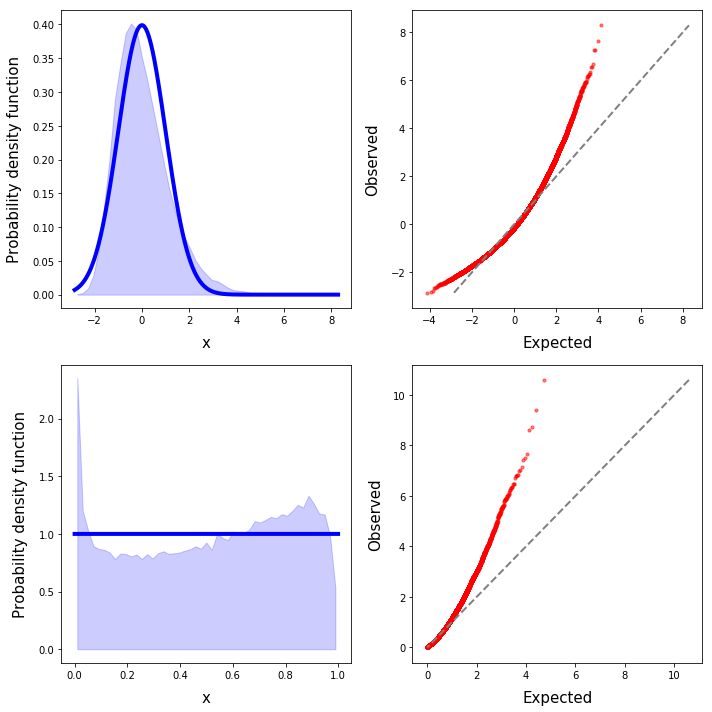

In [67]:
fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

nbins = 50
mu = np.mean(Rsvd_scaled)
plot_hist_qq(ax1, ax2, Rsvd_scaled, nbins, dist = 'normal', loc = 0, scale = 1)
#plot_hist_qq(ax1, ax2, Rsvd_scaled, nbins, dist = 'chisq', loc = 0, scale = 1)
plot_hist_qq(ax3, ax4, pval_R, nbins,dist = 'uniform', loc = 0, scale = 1)


plt.tight_layout()
plt.show()

In [68]:
np.mean(genotype.T, axis = 0)

array([-7.35769105e-17, -5.25549361e-18,  1.10365366e-16, ...,
        1.20876353e-16, -4.20439489e-17, -2.62774680e-17])

In [69]:
np.std(genotype.T, axis = 0)

array([1., 1., 1., ..., 1., 1., 1.])

In [52]:
np.std(Rsvd_scaled)

1.1401457491932803

In [62]:
np.mean(Rsvd_scaled[np.where(Rsvd_scaled >= 0)])

1.0186046665225321

In [61]:
np.where(Rsvd_scaled >= 0)[0]

array([    3,     8,     9, ..., 52629, 52630, 52633])